Kalman Filter, Gerrik
Load the data

In [ ]:
import torch
import numpy as NP
import pandas as PD
import os, scipy, pickle
import matplotlib.pyplot as PLT
import Neural_Decoding as ND
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.decoders import KalmanFilterDecoder

T_B=.05 #Size of time bins in seconds

for File_Add in ["C:/Users/gerri/Coding_Folder/Data_Folder/DS_Final_Data/example_data_hc.pickle"]:
    Mat_Dict=scipy.io.loadmat(File_Add,spmatrix=False)
    Keys=list(Mat_Dict.keys())
    """
    spike_times:    When neurons Fired.
    vels       :    X and Y velocities
    vel_times  :    When vel times were taken.
    pos        :    X and Y positions of a cursor
    acc        :    X and Y accuracy of cursor
    """
    
    #Reformat matlab variables to pandas DF.
    DF=dict()
    DF["Vel_x"]=Mat_Dict["vels"][:,0]
    DF["Vel_y"]=Mat_Dict["vels"][:,1]
    DF["Vel_t"]=NP.concat(Mat_Dict["vel_times"])
    DF["Pos_x"]=Mat_Dict["pos"][:,0]
    DF["Pos_y"]=Mat_Dict["pos"][:,1]
    DF["acc_x"]=Mat_Dict["acc"][:,0]
    DF["acc_y"]=Mat_Dict["acc"][:,1]
    Spike_Times=NP.sort(NP.reshape(Mat_Dict["spike_times"],shape=-1))
    PD.DataFrame(DF)

    neural_data=bin_spikes(
        spike_times=DF["Vel_t"],
        dt=T_B,
        wdw_start=DF["Vel_t"][0],
        wds_end=DF["Vel_t"][-1])
    
    vels_binned=bin_output(
        outputs=Mat_Dict["vels"],
        output_times=DF["Vel_t"],
        dt=         T_B,            #Time bin size==0.05 seconds
        wdw_start=  DF["Vel_t"][0], #Start at first sample
        wdw_end=    DF["Vel_t"][-1],#End at last sample
        downsample_factor=1)

ModuleNotFoundError: No module named 'Neural_Decoding'

As can be seen above, both files contain the same variables.

In [32]:
import torch
import numpy as NP
import pandas as PD
import os, scipy, pickle
import matplotlib.pyplot as PLT
import Neural_Decoding as ND
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.decoders import KalmanFilterDecoder
import sklearn
from matplotlib import pyplot as PLT

training_range=[0, 0.5]
valid_range=[0.5,0.65]
testing_range=[0.65, 0.8]
lag=0


File=open("C:/Users/gerri/Coding_Folder/Data_Folder/DS_Final_Data/example_data_hc.pickle",mode='rb')
[neural_data,pos_binned]=pickle.load(File,)
print(f"neural_data \n{NP.shape(neural_data)}"+"\n"+f"pos_binned \n{NP.shape(pos_binned)}")

"""
neural_data:    When neurons Fired. num_bins x num_neurons. 1 when fired, 0 when not.
pos_binned       :    X and Y velocities
"""

#Remove all rows of pos binned and neural data where pos binned is NaN
rmv_time=NP.where(NP.isnan(pos_binned[:,0]) | NP.isnan(pos_binned[:,1]))
X_kf=NP.delete(neural_data,rmv_time,0)
pos_binned=NP.delete(pos_binned,rmv_time,0)

#get velocity of positions binned
temp=NP.diff(pos_binned,axis=0)
vels_binned=NP.concatenate((temp,temp[-1:,:]),axis=0)

#We now determine acceleration, by taking diff between each position.
temp2=NP.diff(vels_binned,axis=0)
acc_binned=NP.concatenate((temp2,temp2[-1:,:]),axis=0)

#Y_kf is the positions binned, velocities binned, then acc_binned in numpy array.
Y_kf=NP.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

#Center Y along axis=0
# Y_mean=NP.mean(Y_kf,axis=0)
# Y_std=NP.std(Y_kf,axis=0)
# Y_kf=(Y_kf-Y_mean)/Y_std

nd_sum=NP.nansum(X_kf,axis=0) #Total number of spikes of each neuron
nd_mean=NP.mean(nd_sum)
nd_std=NP.std(nd_sum)
nd_thresh=nd_mean-nd_std*2


rmv_nrn=NP.where(nd_sum<100) #Find neurons who have less than 100 spikes total
rmv_nrn_std=NP.where(nd_sum<nd_thresh) #Find neurons who have less than 2 std of dataset. Gerrik
print(f"rmv_nrn \n{NP.shape(rmv_nrn)}"+"\n"+f"rmv_nrn_std \n{NP.shape(rmv_nrn_std)}")

#Centered firing covariance.
Firing_Covariate=NP.delete(X_kf,rmv_nrn,1)
Firing_Covariate_G=NP.delete(X_kf,rmv_nrn,1)

#If there is known lag between the two datasets.
num_examples=X_kf.shape[0]
if lag==0:
    print("No lag")
elif lag<0:
    Y_kf=Y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
elif lag>0:
    Y_kf=Y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]


num_examples_kf=X_kf.shape[0]    

neural_data 
(28039, 58)
pos_binned 
(28039, 2)
rmv_nrn 
(1, 12)
rmv_nrn_std 
(1, 0)
No lag


R2: [-0.2145409   0.05545309]
rho2: [0.0030694  0.06994287]
R2: [-0.22401645  0.05260956]
rho2: [0.00282348 0.07171173]


C:\Users\gerri\AppData\Local\Temp\ipykernel_14696\4194053715.py:19: RuntimeWarning: invalid value encountered in divide
  X_kf_train=(X_Train-X_kf_train_mean)/X_kf_train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_14696\4194053715.py:20: RuntimeWarning: divide by zero encountered in divide
  X_kf_test=(X_Test-X_kf_train_mean)/X_kf_train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_14696\4194053715.py:20: RuntimeWarning: invalid value encountered in divide
  X_kf_test=(X_Test-X_kf_train_mean)/X_kf_train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_14696\4194053715.py:21: RuntimeWarning: divide by zero encountered in divide
  X_kf_valid=(X_Valid-X_kf_train_mean)/X_kf_train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_14696\4194053715.py:21: RuntimeWarning: invalid value encountered in divide
  X_kf_valid=(X_Valid-X_kf_train_mean)/X_kf_train_std


LinAlgError: Singular matrix

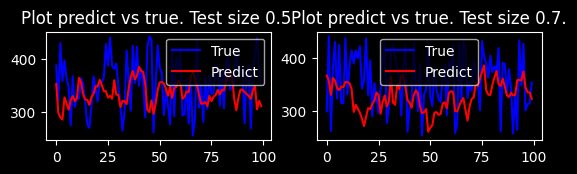

In [ ]:
for IDX,Test_Size in enumerate([0.5,0.7,0.8]):
    X_Train, X_Test, Y_Train, Y_Test =sklearn.model_selection.train_test_split(X_kf,Y_kf,test_size=Test_Size)
    X_Valid, X_Test, Y_Valid, Y_Test =sklearn.model_selection.train_test_split(X_Test,Y_Test,test_size=Test_Size)
    
    #Need to recenter, because Simpson's paradox. The grey doesnt work, but second centering does for some reason.
    # X_kf_train_mean=NP.nanmean(X_Train,axis=0)
    # X_kf_train_std=NP.nanstd(X_Train,axis=0)
    # X_kf_valid_mean=NP.nanmean(X_Train,axis=0)
    # X_kf_valid_std=NP.nanstd(X_Train,axis=0)
    # X_kf_test_mean=NP.nanmean(X_Train,axis=0)
    # X_kf_test_std=NP.nanstd(X_Train,axis=0)
    # X_Train=(X_Train-X_kf_train_mean)/X_kf_train_std
    # X_Test=(X_Test-X_kf_test_mean)/X_kf_test_std
    # X_Valid=(X_Valid-X_kf_valid_mean)/X_kf_valid_std
    
    #I think what is happening is that the test and valid are small.
    X_kf_train_mean=NP.nanmean(X_Train,axis=0)
    X_kf_train_std=NP.nanstd(X_Train,axis=0)
    X_kf_train=(X_Train-X_kf_train_mean)/X_kf_train_std
    X_kf_test=(X_Test-X_kf_train_mean)/X_kf_train_std
    X_kf_valid=(X_Valid-X_kf_train_mean)/X_kf_train_std
    
    y_kf_train_mean=NP.mean(Y_Train,axis=0)
    y_kf_train=Y_Train-y_kf_train_mean
    y_kf_test=Y_Test-y_kf_train_mean
    y_kf_valid=Y_Valid-y_kf_train_mean
    
    #Declare model
    Model_kf=KalmanFilterDecoder(C=5) #There is one optional parameter (see ReadMe)

    #Fit model, there is some bug where it keeps saying there is a singula matrix, which I think is because of how the populations are divided. The error IS based on the random state.
    Model_kf.fit(X_Train,Y_Train)

    #Get predictions
    y_valid_predicted_kf=Model_kf.predict(X_Valid,Y_Valid)
    

    #Get metrics of fit (see read me for more details on the differences between metrics)
    #First I'll get the R^2
    R2_kf=get_R2(Y_Valid,y_valid_predicted_kf)
    print('R2:',R2_kf[0:2]) #I'm just printing the R^2's of the 1st and 2nd entries that correspond to the positions
    #Next I'll get the rho^2 (the pearson correlation squared)
    rho_kf=get_rho(Y_Valid,y_valid_predicted_kf)
    print('rho2:',rho_kf[0:2]**2) #I'm just printing the rho^2's of the 1st and 2nd entries that correspond to the positions
    
    PLT.subplot(3,2,IDX+1)
    PLT.plot(Y_Valid[2000:2100,0]+y_kf_train_mean[0],'b',label="Raw")
    PLT.plot(y_valid_predicted_kf[2000:2100,0]+y_kf_train_mean[0],'r',label="Predict")
    PLT.title(f"Plot predict vs true. Test size {Test_Size}.")
    PLT.legend()